In [1]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu,SmoothingFunction
import pandas as pd
import numpy as np
import docker
import os
import re
import random
from string import punctuation
import json
import matplotlib.pyplot as plt
punc = punctuation
smooth = SmoothingFunction()

In [2]:
def patternDeal(sol, num):
    if num == 6:
        return [ 
                {
                    'itemName' : item.split(':')[0],
                    'rows' : [ i.strip() for i in item.split(':')[1].split(',') ]
                      }  for item in sol[1:] if ':' in item and 'uint' in item.split(':')[0] and 'uint256' not in item.split(':')[0]
                ]
    return [ 
                {
                    'itemName' : item.split(':')[0],
                    'rows' : [ i.strip() for i in item.split(':')[1].split(',') ]
                      }  for item in sol[1:] if ':' in item 
                ]

#将结果分割，需要不同的split字符串
def getGasResList(address, num):
    pat = open(address,'r').read()
    patList = re.split('\n[0-9]+ : ', pat)#
    ans = {}
    for sol in patList:
        if 'success' not in sol:
            continue
        sol = sol.split('\n')
        sol = sol[:-1]
        if sol[0] in ans.keys():
            ans[sol[0]] += patternDeal(sol, num)
        else:
            ans[sol[0]] = patternDeal(sol, num)
    return ans

#匹配gasPattern与克隆对的范围
def matchRange(item, contract_line):
    return int(item['rows'][0].strip()) >= eval(contract_line)[0] and int(item['rows'][1].strip()) <= eval(contract_line)[1]

#当克隆对合约在patList内，并且范围正确，旧获得
def compareRange(pat, contract_line, name):

    return  [
        item['rows'] for item in pat[name] if matchRange(item, contract_line)
    ] if name in pat.keys() else None

#将gas结果加到bb内
def GasAppendByRange(bb,pat,num):
    bb['pattern{}'.format(num)] = [ compareRange(pat, item[1]['contract_line'], item[1]['code_name'].split('.')[0]) for item in bb.iterrows() ]

def runGasPattern(patNum, rootAddress, bb):
    for num in patNum:
    #切割
        pat = getGasResList(os.path.join(rootAddress,'gasDetectResult{}.txt').format(num), num)
        GasAppendByRange(bb, pat, num)
        
#多种结果mapping到十种情况中
head = [' access_control ',
 ' arithmetic ',
 ' denial_service ',
 ' reentrancy ',
 ' unchecked_low_calls ',
 ' bad_randomness ',
 ' front_running ',
 ' time_manipulation ',
 ' short_addresses ',
 ' Other ',
 ' Ignore ']
dic = dict(zip(head,[0]*10))
mapping = open('/home/yfliu/mapping.json').read()
mapp = json.loads(mapping)
#重要程度

slither_map = mapp['slither']
slither_key = slither_map.keys()
slither_type_map = dict(zip(slither_key,[0]*len(slither_key)))
u = open('/home/yfliu/paper/trash/temp.txt').read()
for i in u.splitlines():
    sp = i.split()
    slither_type_map[sp[1]] = sp[-2]
slither_type_map
slither_type_map['constant-function'] = 'Medium'
slither_bug_patch = ['constable-states','erc20-indexed','erc20-interface','external-function','incorrect-equality','naming-convention','shadowing-local','shadowing-state','shadowing-builtin','shadowing-abstract']

def smallerRange(oldNum, lineNum):
    if len(oldNum) < 1 or len(lineNum) < 1:
        print('great error')
        return False
    #print(oldNum)
    #print(lineNum)
    oldStart = oldNum[0]
    oldEnd = oldNum[-2]
    lineStart = lineNum[0]
    lineEnd = lineNum[-2]
    return lineStart >= oldStart and lineEnd <= oldEnd
def updateMap(res, title, lineNum,reuse):
    #lineNum = [lineNum] if type(lineNum) == int else lineNum
    if type(lineNum) == int:
        lineNum = [lineNum,reuse]
    else:
        lineNum.append(reuse)
    lineOldNum = res[title]
    for oldNum in lineOldNum:
        #print(oldNum)
        if smallerRange(oldNum, lineNum):
            return
    res[title].append(lineNum)
    
def subDict(dict1, dict2):
    res = {}
    for item in dict1.keys():
        if item not in dict2.keys():
            res[item] = dict1[item]
        elif dict1[item] - dict2[item] > 0:
            res[item] = dict1[item] - dict2[item]
    return res
    
def getCount(mapRes):
    resCount = {}
    for item in mapRes:
        if len(item) > 0:
            for bugName in item.keys():
                count = 0
                for i in item[bugName]:
                    count += int(i[-1])
                if bugName in resCount.keys():
                    resCount[bugName] += count
                else:
                    resCount[bugName] = count
    return resCount
toolNames = ['mythril_analysis_not_info','osiris_analysis','slither_analysis_not_info']
#toolNames = ['mythril_analysis_not_info','osiris_analysis']
#toolNames = ['mythril_analysis_not_info']
def get(cc, toolNames):
    mapRes = []
    for index,row in cc.iterrows():
        #同行算消除
        res = {}
        #print(row)
        reuse = int(row['reuse'])
        for toolName in toolNames:
            toolRes = row[toolName]
            for tRes in toolRes:
                #print(tRes)
                #tRes = eval(tRes)
                lineNum = tRes['lineno']
                title = mapp[toolName.split('_')[0]][tRes['title'].strip()]#已经转换过
                if title in res.keys():
                    updateMap(res, title, lineNum,reuse)
                else:
                    if type(lineNum) == int:
                        res[title] = [[lineNum,reuse]]
                    else:
                        lineNum.append(reuse)
                        res[title] = [lineNum]
                    #res[title] = [[lineNum,reuse] if type(lineNum) == int else lineNum.append(reuse)]#使用lineNum--list的len计算数量 [[],[]]
            #temp = [res]
            #print(getCount(temp))
        mapRes.append(res)
        #print(mapRes)
    resCount =  getCount(mapRes)
    return resCount

def countBugRes(data):
    print('mythril: {}'.format( get(data, ['mythril_analysis_not_info']) ))
    print('osiris: {}'.format(subDict(get(data, ['mythril_analysis_not_info','osiris_analysis']), get(data, ['mythril_analysis_not_info']))))
    print('slither: {}'.format( subDict(get(data, ['mythril_analysis_not_info','osiris_analysis','slither_analysis_not_info']), get(data, ['mythril_analysis_not_info','osiris_analysis'])) ))
    print('total:',end=' ')
    total = get(data, ['mythril_analysis_not_info','osiris_analysis','slither_analysis_not_info'])
    count = 0
    for item in total:
        count += total[item]
    print(total)
    print(count)

In [3]:
dataAddr = '/home/yfliu/paper_data/astResultCsv/contractResBleuGas.pic'

In [92]:
conAst = pd.read_pickle('/home/yfliu/paper_data/astResultCsv/contractRes_v2.pic')
funAst = pd.read_pickle('/home/yfliu/paper_data/astResultCsv/functionRes_v2.pic')
def temp(name,data):
    return data[data[name].apply(lambda x : x != None and len(x) > 0)]
con = temp('slither_analysis_not_info', conAst).append(temp('mythril_analysis_not_info', conAst)).append(temp('osiris_analysis', conAst))
conG = temp('pattern1', conAst).append(temp('pattern2', conAst)).append(temp('pattern3', conAst)).append(temp('pattern4', conAst)).append(temp('pattern6', conAst)).append(temp('pattern7', conAst))
#fun = temp('slither_analysis_not_info', funAst).append(temp('mythril_analysis_not_info', funAst)).append( temp('osiris_analysis', funAst))
#funG = temp('pattern1', funAst).append( temp('pattern2', funAst) ).append( temp('pattern3', funAst)).append( temp('pattern4', funAst)).append( temp('pattern6', funAst)).append( temp('pattern7', funAst))


In [94]:
con['conName'] = con['contract_code'].apply(lambda x : x.split(' ')[1].split('{')[0].split('\n')[0])
conG['conName'] = conG['contract_code'].apply(lambda x : x.split(' ')[1].split('{')[0].split('\n')[0])

In [96]:
reuses = reuseRes.merge(conG,on=['name','conName'],how='inner')
#查找开源合约的扩散
ans = []
for item in list(reuses.drop_duplicates('id')['id']):
    #print(item,end = ' ')
    temp = list(reuseRes[reuseRes['id'] == item]['name'].drop_duplicates())
    #print(len(temp))
    ans += temp
len(set(ans))

28317

In [95]:
reuses = reuseRes.merge(con,on=['name','conName'],how='inner')
#查找开源合约的扩散
ans = []
for item in list(reuses.drop_duplicates('id')['id']):
    #print(item,end = ' ')
    temp = list(reuseRes[reuseRes['id'] == item]['name'].drop_duplicates())
    #print(len(temp))
    ans += temp
len(set(ans))

11903

In [11]:
reuses = reuseRes.merge(data,on=['name','conName'],how='inner')
#查找开源合约的扩散
ans = []
for item in list(reuses.drop_duplicates('id')['id']):
    #print(item,end = ' ')
    temp = list(reuseRes[reuseRes['id'] == item]['name'].drop_duplicates())
    #print(len(temp))
    ans += temp
len(set(ans))
#ans
#reuses.drop_duplicates('id')

In [ ]:
#所有包含漏洞

In [72]:
#所有代码片段

98980

In [24]:
qwe = 0
for item in list(reuses['reuse'].apply(lambda x: eval(x))):
    qwe += item

mythril: {' access_control ': 8, ' front_running ': 59, ' reentrancy ': 1053, ' arithmetic ': 3895, ' Other ': 17}
osiris: {' arithmetic ': 46183, ' reentrancy ': 3, ' Ignore ': 135, ' denial_service ': 10, ' time_manipulation ': 13}
slither: {' access_control ': 35, ' reentrancy ': 48, ' unchecked_low_calls ': 205, ' denial_service ': 781, ' time_manipulation ': 8, ' Other ': 7}
total: {' arithmetic ': 50078, ' access_control ': 43, ' front_running ': 59, ' reentrancy ': 1100, ' unchecked_low_calls ': 188, ' Ignore ': 135, ' denial_service ': 431, ' time_manipulation ': 17, ' Other ': 23}
52074
1 31203
6 29747
2 24
3 21
4 17487
7 45


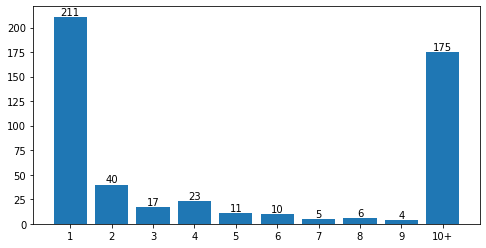

In [4]:
data = pd.read_pickle(dataAddr)
data['conName'] = data['contract_code'].apply(lambda x : x.split(' ')[1].split('{')[0].split('\n')[0])

reuseRes = pd.read_pickle('/home/yfliu/paper_data/proliData/proliData.pic')
temp = reuseRes.merge(data,on=['name','conName'],how='right')
temp['reuse'] = temp['reuse'].apply(lambda x : int(x) if type(x) != float else 1)

#bug
countBugRes(temp)

#gas
patNum = [1,6,2,3,4,7]
for item in patNum:
    print(item,end=' ')
    count = 0
    for idx,row in temp.iterrows():
        reuse = row['reuse']
        pat = row['pattern{}'.format(item)]
        if pat != None and len(pat) > 0:
            count += reuse
    print(count)

#make picture
countTemp = temp.drop_duplicates(['name','conName'])

def count_reuse(new_df,num):
    return len(new_df[new_df['reuse'] == num])
def count_out_reuse(new_df,num):
    return len(new_df[new_df['reuse'] >= num])
num_count = []
for i in range(1,10):
    num_count.append(count_reuse(countTemp,i))
num_count.append(count_out_reuse(countTemp,10))
num_count


def barr(keys,values):
    fig = plt.figure(figsize=(8,4))
    plt.bar(keys, values)
    for a,b in zip(keys,values):
        plt.text(a, b+0.01, '%.0f' % b, ha='center', va= 'bottom')
    plt.xticks()
    #plt.xlabel("Distribution of contract duplication")
    #plt.ylabel("Contract count")
    plt.show()
#num_count = num_count
barr(['1','2','3','4','5','6','7','8','9','10+'],num_count)

In [5]:
'''#生成重用的csv
idList = open('/home/yfliu/paper_data/proliData/ids_for_each_contract.txt').read().split('\n')[:-1]
reuseList = open('/home/yfliu/paper_data/proliData/normalized_tokens_deduplicated.txt').read().split('\n')[:-1]
idList = pd.Series(idList)
idList = pd.DataFrame({
    'name': idList.apply(lambda x : x.split(',')[0]),
    'conName': idList.apply(lambda x : x.split(',')[1]),
    'id': idList.apply(lambda x : x.split(',')[2])
}) 
reuseList = pd.Series(reuseList)
reuseList = pd.DataFrame({
    'id': reuseList.apply(lambda x : x.split(',')[0]),
    'reuse': reuseList.apply(lambda x : x.split(',')[1])
}) 
reuseList
reuseRes = idList.merge(reuseList,on='id',how='left')
reuseRes.to_pickle('/home/yfliu/paper_data/proliData/proliData.pic')'''

"#生成重用的csv\nidList = open('/home/yfliu/paper_data/proliData/ids_for_each_contract.txt').read().split('\n')[:-1]\nreuseList = open('/home/yfliu/paper_data/proliData/normalized_tokens_deduplicated.txt').read().split('\n')[:-1]\nidList = pd.Series(idList)\nidList = pd.DataFrame({\n    'name': idList.apply(lambda x : x.split(',')[0]),\n    'conName': idList.apply(lambda x : x.split(',')[1]),\n    'id': idList.apply(lambda x : x.split(',')[2])\n}) \nreuseList = pd.Series(reuseList)\nreuseList = pd.DataFrame({\n    'id': reuseList.apply(lambda x : x.split(',')[0]),\n    'reuse': reuseList.apply(lambda x : x.split(',')[1])\n}) \nreuseList\nreuseRes = idList.merge(reuseList,on='id',how='left')\nreuseRes.to_pickle('/home/yfliu/paper_data/proliData/proliData.pic')"